In [1]:
%matplotlib notebook

import os,time
import tables as tb
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
import tjmonopix.analysis.interpreter_idx
import tjmonopix.analysis.interpreter_old
import pixel_clusterizer.clusterizer

COL=112
ROW=224
CALCAP=33

datdir="/sirrush/thirono/2019-01-03/tjmonopix"

In [13]:
#### functions
@njit
def _cal_tot(hits,totsum,cnt,over_flow_idx=40,over_flow_tot=32):
    #print len(hits)
    for h_i, h in enumerate(hits):
        #if h['index']!=0:
        #    print h["col"],h['row'],h['index'],totsum[h["col"],h['row'],h['index']],
        #    print float((h['te']-h['le'])&0x3F)
            #return
        tot=np.float32((h['te']-h['le'])&0x3F)
        #if tot < over_flow_tot and h['scan_param_id']>over_flow_idx:
        #    tot=tot+64.
        cnt[h["col"],h['row'],h['scan_param_id']]=cnt[h["col"],h['row'],h['scan_param_id']]+1
        totsum[h["col"],h['row'],h['scan_param_id']]=totsum[h["col"],h['row'],h['scan_param_id']]+tot
        #if h['index']!=0:
        #    print cnt[h["col"],h['row'],h['index']],totsum[h["col"],h['row'],h['index']],
        #    print float((h['te']-h['le'])&0x3F)
        #    return totsum,cnt
    return totsum,cnt

def get_totave(fth_hit,over_flow_idx=40,over_flow_tot=32):
    with tb.open_file(fth_hit,"a") as f:
        hits=f.root.Hits[:]
        print "all",len(hits),
        hits=hits[hits["col"]<COL]
        print "tj",len(hits)
        injlist=np.arange(0,100-35,1) ## TODO take from file...
        tot=np.zeros([COL,ROW,len(injlist)],dtype=np.float32)
        cnt=np.zeros([COL,ROW,len(injlist)],dtype=np.int32)
        tot,cnt=_cal_tot(hits,tot,cnt,over_flow_idx=over_flow_idx,over_flow_tot=over_flow_tot)
        tot=tot/np.array(cnt,dtype=np.float32)
        try:
            f.remove_node(f.root,"Scurve")
            f.remove_node(f.root,"ToTAve")
        except:
            pass
        f.create_carray(f.root, 
               name='Scurve', title='scurve', obj=cnt,
               filters=tb.Filters(complib='blosc', complevel=5, fletcher32=False))
        tot_tbl=f.create_carray(f.root, 
               name='ToTAve', title='tot average', obj=tot ,
               filters=tb.Filters(complib='blosc', complevel=5, fletcher32=False))
        tot_tbl.attrs.bins=injlist
        return tot,injlist
    
    
@njit
def _convert(cal_data,bins,hits,buf):
    for i,h in enumerate(hits): 
        th=float((h['te']-h['le'])&0x3F)
        y=cal_data[h['col'],h['row']]
        #tmp=np.abs(vlist-th)
        #pre=tmp[0]
        #for a1,v in enumerate(tmp[1:]):
        #    if pre < v:
        #        break
        #    else:
        #        pre=v
        if np.all(np.isnan(y)):
            buf[i]=1.0 ### disabled pixel?
            continue
        x=bins[~np.isnan(y)]
        y=y[~np.isnan(y)]

        a_min=np.argmin(y)
        x=x[a_min:]
        y=y[a_min:]
        
        tmp=np.abs(y-th)
        a1=np.argmin(tmp)
        if a1==0:
            a2=a1+1
        elif tmp[a1+1]>tmp[a1-1]:
             a2=a1-1
        else:
             a2=a1+1
        if np.isnan(y[a1]):
            buf[i]=x[0]-(x[1]-x[0])
        elif  np.isnan(y[a2]) or y[a2]==y[a1]:
            buf[i]=x[a1]
        else:
            buf[i]=(x[a2]-x[a1])/(y[a2]-y[a1])*(th-y[a1])+x[a1]
    return buf

@njit
def _build(hits,buf):
    event_number=hits[0]['timestamp']
    for i,h in enumerate(hits):
        if h['cnt']==0:
            buf[i]['event_number']=np.int64(h['timestamp'])
            event_number=np.int64(h['timestamp'])
        else:
            buf[i]['event_number']=event_number
        #print i, buf[i]['event_number'],h['cnt']
    return buf
        

def event_build_and_clusterize(fhit,cal_data=None,chunck_size=10000000,max_hits=50):

    ev_type=[("event_number","<i8"),("event_timestamp","<u8"),
             ("frame","<u1"),("column","<u1"),("row","<u1"),
             ("charge","<f4"),('flg','<u1')]
    clh_type=[('event_number', '<i8'), ('event_timestamp', '<u8'), 
             ('frame', 'u1'), ('column', 'u1'), ('row', 'u1'), ('charge', '<f4'), 
             ('flg', 'u1'), ('cluster_ID', '<i2'), 
             ('is_seed', 'u1'), ('cluster_size', '<u2'), ('n_cluster', '<u2')]
    cl_type =[('event_number', '<i8'), ('ID', '<u2'), ('n_hits', '<u2'), ('charge', '<f4'), 
              ('seed_column', '<u2'), ('seed_row', '<u2'), 
              ('mean_column', '<f4'), ('mean_row', '<f4')]

    buf=np.empty(chunck_size,dtype=ev_type)
    ev_buf=np.empty(chunck_size,dtype=np.int64)
        
    with tb.open_file(fhit,"a") as f:
        if cal_data is None:
            pass
        else:
            if isinstance(cal_data,str):
                with tb.open_file(cal_data,"r") as fcal:
                    cal_data=fcal.root.ToTAve[:]
                    bins=fcal.root.ToTAve.attrs.bins
            else:
                bins=np.arange(0,len(cal_data[0,0,:]),1)    ## TODO get from arg
            cal_data[:,:,0]=float("nan") #delete first data
            try:
                f.remove_node(f.root,"ToTAve")
            except:
                pass
            f.create_carray(f.root, 
                   name='ToTAve', title='tot average', obj=cal_data ,
                   filters=tb.Filters(complib='blosc', complevel=5, fletcher32=False))
            conv_buf=np.empty(chunck_size,dtype=np.float64)
        
        try:
            f.remove_node(f.root,"Events")
        except:
            pass
        table_ev=f.create_table(f.root,name="Events",
                       description=np.zeros(0,dtype=ev_type).dtype,
                       title="event data")

        try:
            f.remove_node(f.root,"Clusters")
            f.remove_node(f.root,"ClusterHits")
        except:
            pass
        table_cl=f.create_table(f.root,name="Clusters",
                       description=np.zeros(0,dtype=cl_type).dtype,
                       title="clustered data")
        table_clh=f.create_table(f.root,name="ClusterHits",
                       description=np.zeros(0,dtype=clh_type).dtype,
                       title="cluster hits data")
        cl=pixel_clusterizer.clusterizer.HitClusterizer()
        cl.set_min_hit_charge(0)
        cl.set_column_cluster_distance(2)
        cl.set_row_cluster_distance(2)
        cl.set_frame_cluster_distance(64)
        cl.set_hit_dtype(np.zeros(0,dtype=ev_type).dtype)

        start=0
        end=len(f.root.Hits)
        t0=time.time()
        while start<end:
            tmpend=min(start+chunck_size, end)
            hits=f.root.Hits[start:tmpend]
            if tmpend!=end:
                last_data=None
                for i in range(tmpend-start-1,-1,-1):
                    i_data=hits[i]
                    #print i,i_data
                    if last_data is None and i_data['col']<COL and i_data['cnt']==0:
                        last_data=hits[i]
                        #print "get last_data"
                    elif last_data is not None \
                        and i_data['col']<COL \
                        and last_data["timestamp"]!=i_data["timestamp"]:
                            #print "break"
                            break
                tmpend=start+i+1
                if i==0:
                    start=tmpend
                    print 'set chunck_size larger than %d'%chunk_size
                    break

            hits=hits[:tmpend-start]
            hits=hits[hits['col']<COL]
            print "idx=%d-%d(tj=%d)"%(start,tmpend,hits.shape[0]),
            if start==0: ## cut data before reset
                a_min=np.argmin(hits["timestamp"])
                t_min=hits[a_min]['timestamp']
                hits=hits[a_min:]
            else:
                if np.min(hits['timestamp'])< t_min:
                    print "ERROR timestamp error!!!"
            ndata=hits.shape[0]
            print "data=%d %.1fs"%(ndata,time.time()-t0),
            
            buf[:ndata]=_build(hits,buf[:ndata])
            buf['frame'][:ndata]=hits["le"][:ndata]
            buf["event_timestamp"][:ndata]=hits["timestamp"]
            buf['column'][:ndata]=hits["col"]
            buf['row'][:ndata]=hits["row"]
            buf['flg'][:ndata]=hits["cnt"]
            print "build %.1fs"%(time.time()-t0),
        
            if cal_data is not None:
                buf["charge"][:ndata] = _convert(cal_data,bins,hits,conv_buf[:ndata])
            else:
                buf["charge"][:ndata]=np.array((hits['te']-hits['le'])&0x3F,dtype=np.float32)+1.0
            table_ev.append(buf[:ndata])
            table_ev.flush()
            print " convert %.1fs"%(time.time()-t0),
            
            buf['column']=buf['column']+1
            buf['row']=buf['row']+1
            uni,idx,cnt=np.unique(buf["event_timestamp"][:ndata],
                                  return_index=True,return_counts=True)
            idx=idx[cnt>max_hits]
            cnt=cnt[cnt>max_hits]
            cut=0
            for i,idx_i in enumerate(idx):
                buf[idx_i:idx_i+cnt[i]]['column']=0
                cut=cut+cnt[i]
            print " delete too_many_hits=%d %.1fs"%(len(buf[:ndata][buf[:ndata]['column']!=0]),time.time()-t0),
            
            cluster_hits,clusters=cl.cluster_hits(buf[:ndata][buf[:ndata]['column']!=0])
            cluster_hits['column']=cluster_hits['column']-1
            cluster_hits['row']=cluster_hits['row']-1
            clusters['seed_column']=clusters['seed_column']-1
            clusters['seed_row']=clusters['seed_row']-1
            clusters['mean_column']=clusters['mean_column']-1
            clusters['mean_row']=clusters['mean_row']-1
            table_clh.append(cluster_hits)
            table_clh.flush()
            table_cl.append(clusters)
            table_cl.flush()

            print "%.1fs %.2f%% done"%(time.time()-t0,100.0*tmpend/end)
            start=tmpend
            #break

In [11]:
col=50
row=150

subdir=os.path.join(datdir,"th")
fth_raw=os.path.join(subdir,"hv_test.h5")
fcal_data=fth_raw[:-3]+"_hit.h5"
if False: 
    ## run once 
    tjmonopix.analysis.interpreter_idx.interpret_idx_h5(fth_raw,fcal_data)
    ## run if you change _cal_tot() or get_totave()
    get_totave(fcal_data)
with tb.open_file(fcal_data) as f:
    tot=f.root.ToTAve[:][col,row,:]
    th=f.root.ToTAve.attrs.bins
plt.plot(th,tot,".")

In [14]:
subdir=os.path.join(datdir,"run100")
fraw=os.path.join(subdir,"tjmonopix_100_180420-062314.h5")
fout=fraw[:-3]+"_hit.h5"
if False: #run once
    tjmonopix.analysis.interpreter_old.interpret_h5(fraw,fout)
## run if you change the 2nd cell 
event_build_and_clusterize(fout,cal_data=fcal_data,chunck_size=10000000,max_hits=50)

idx=0-9999994(tj=3083231) data=3056578 1.8s build 2.0s  convert 5.2s  delete too_many_hits=548361 5.4s 5.4s 23.74% done
idx=9999994-19999988(tj=2458157) data=2458157 7.2s build 7.3s  convert 9.5s  delete too_many_hits=2458157 9.7s 10.0s 47.47% done
idx=19999988-29999976(tj=2462718) data=2462718 11.7s build 11.8s  convert 14.0s  delete too_many_hits=2462718 14.2s 14.5s 71.21% done
idx=29999976-39999956(tj=2457396) data=2457396 16.2s build 16.3s  convert 18.5s  delete too_many_hits=2457396 18.7s 19.0s 94.95% done
idx=39999956-42127801(tj=552676) data=552676 19.3s build 19.3s  convert 19.9s  delete too_many_hits=552676 20.0s 20.1s 100.00% done


<IPython.core.display.Javascript object>


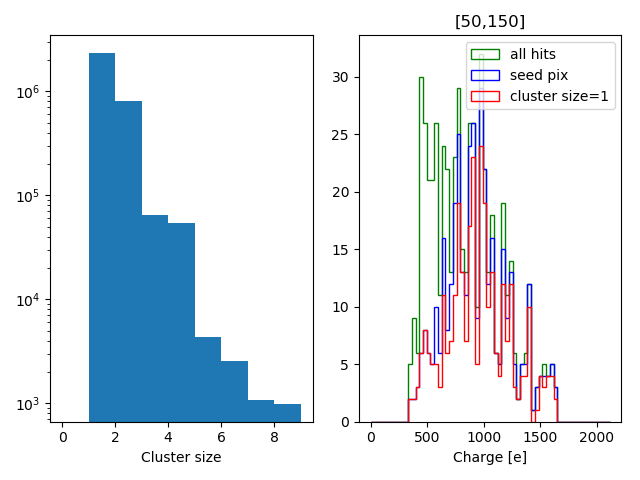

cluster size:1.3486


In [15]:
row=150
col=50

bins=np.arange(0,100-35,1)*CALCAP
fig,ax=plt.subplots(1,2)
with tb.open_file(fout) as f:
    hits=f.root.Clusters[:]
    hits=hits[hits['seed_column']>=COL/2]
    print "cluster size:%.4f"%(np.average(hits["n_hits"]*1.0))
    
    ax[0].hist(hits["n_hits"],bins=np.arange(0,10,1))
    ax[0].set_yscale("log")
    
    hits=f.root.ClusterHits[:]
hits=hits[np.bitwise_and(hits['column']==col,hits['row']==row)]
ax[1].hist(hits['charge']*CALCAP,bins=bins,histtype="step",color="g",label="all hits")
hits=hits[hits['is_seed']==1]
ax[1].hist(hits['charge']*CALCAP,bins=bins,histtype="step",color="b",label="seed pix")
hits=hits[hits['cluster_size']==1]
ax[1].hist(hits['charge']*CALCAP,bins=bins,histtype="step",color="r",label="cluster size=1")
ax[1].set_title("[%d,%d]"%(col,row))
ax[0].set_xlabel("Cluster size")
ax[1].set_xlabel("Charge [e]")
ax[1].legend()
fig.tight_layout()